<a href="https://colab.research.google.com/github/svishakan/Intro-to-ML/blob/main/Food%20Classification/Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Classification Using Artificial Neural Networks

In [1]:
#Importing the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, ImageColorGenerator

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as bas, matthews_corrcoef as mcc, confusion_matrix, classification_report, accuracy_score

!pip install geopandas
!pip install pywaffle
!pip install imbalanced-learn

import geopandas as gpd
from pywaffle import Waffle
from imblearn.over_sampling import RandomOverSampler

     |████████████████████████████████| 1.0MB 4.4MB/s 
     |████████████████████████████████| 15.3MB 256kB/s 
     |████████████████████████████████| 6.5MB 37.4MB/s 
     |████████████████████████████████| 532kB 4.3MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [2]:
#Mount indian_food.csv and modify path accordingly

#Google Drive Authorization
from google.colab import drive
drive.mount('/content/drive')

PATH_TO_DATA = "/content/drive/MyDrive/Colab Notebooks/Datasets/indian_food.csv"

df = pd.read_csv(PATH_TO_DATA)
df = df.replace(-1, np.nan)
df = df.replace("-1", np.nan)

Mounted at /content/drive


## Getting to know the dataset

In [3]:
#Visualising how the dataset looks like
df.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,West Bengal,East


The dataset consists of about 255 Indian dishes and 9 columns associated with each of them.

The 9 columns are as follows:-

name: Name of the dish

ingredients: Main ingredients used

diet: type of diet - Either vegetarian or non vegetarian

prep_time: Preparation time

cook_time: Cooking time

flavor_profile: Flavor profile includes whether the dish is spicy, sweet, bitter, etc

course: Course of meal - starter, main course, dessert, etc

state: State where the dish is famous or is originated

region: Region where the state belongs

In [4]:
#Dimensions of the dataset
df.shape

(255, 9)

In [5]:
#Some statistics regarding the dataset
df.describe()

,prep_time,cook_time
count,225.000000,227.000000
mean,35.386667,38.911894
std,76.241081,49.421711
min,5.000000,2.000000
25%,10.000000,20.000000
50%,10.000000,30.000000
75%,20.000000,45.000000
max,500.000000,720.000000


In [6]:
pie_data = df.diet.value_counts().reset_index()
pie_data.columns = ['diet', 'count']

figure = px.pie(pie_data, values='count', names='diet', title='Proportion of Vegatarian to Non-Vegetarian Dishes', color_discrete_sequence=['green', 'orange'])
figure.show()

The variable is highly imbalanced. Almost 87% of the food is vegetarian.

In [7]:
region_data = df.region.value_counts().reset_index()
region_data.columns = ['region', 'count']
region_data = region_data.sample(frac=1)

figure = px.bar(region_data, x='region', y='count', title='Dish Count based on Region', color_discrete_sequence=['violet'])
figure.show()

In [8]:
course_data = df.course.value_counts().reset_index()
course_data.columns = ['course', 'count']
course_data = course_data.sample(frac=1)

figure = px.bar(course_data, x='course', y='count', title='Dish Count based on Courses of Meal', color_discrete_sequence=['blue'])
figure.show()

In [9]:
pie_data = df.flavor_profile.value_counts().reset_index()
pie_data.columns = ['flavor','count']

figure = px.pie(pie_data, values='count', names='flavor', title='Proportion of Flavor Profiles',
             color_discrete_sequence=['#FF7F0E', '#00B5F7','#AB63FA','#00CC96'])
figure.show()

More than 50% of the dishes are spicy, whereas only 0.44% of the dishes are sour.

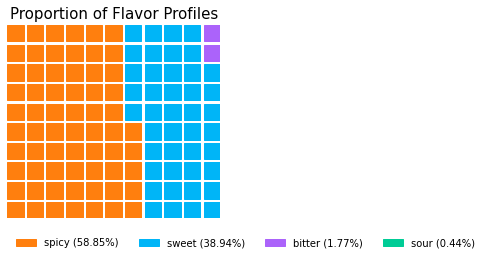

In [10]:
#Visualization in the form of a Waffle image, which denotes the same info
#as the above pie-chart, but in a different manner.

data = dict(df['flavor_profile'].value_counts(normalize = True) * 100)

flavor = ['spicy','sweet','bitter','sour'] 
            

fig = plt.figure( 
    rows=10,
    columns=11,
    FigureClass = Waffle, 
    values = data, 
    title={'label': 'Proportion of Flavor Profiles', 'loc': 'center',
          'fontsize':15},
    colors=("#FF7F0E", "#00B5F7", "#AB63FA","#00CC96"),
    labels=[f"{k} ({v:.2f}%)" for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': len(data), 'framealpha': 0},
    figsize=(6, 8)
)

In [11]:
#To do: Add more graphs and detailing of the data
#       https://www.kaggle.com/upadorprofzs/indian-food-eda-data-visualization

### Word Clouds for Visualisation

#### Ingredients Used in Desserts

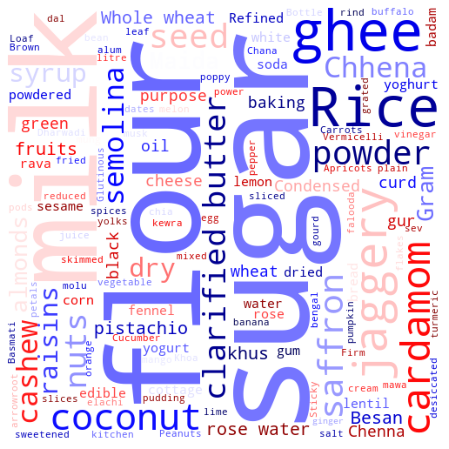

In [12]:
dessert_data  = df[df['course']=='dessert'].reset_index()

ingredients = []
for i in range(0,len(dessert_data)):
    text = dessert_data['ingredients'][i].split(',')
    text = ','.join(text)
    ingredients.append(text)
    text = ' '.join(ingredients)

wordcloud = WordCloud(width = 500, height = 500, colormap = 'seismic',
                      background_color ='white', min_font_size = 10).generate(text)                  

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

#### Ingredients Used in North-Indian Cuisine

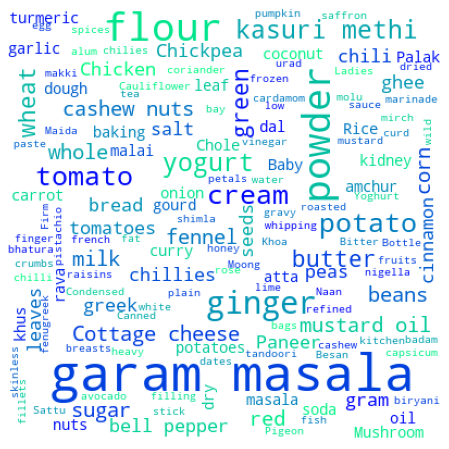

In [13]:
north_data = df[df['region']=='North'].reset_index()

ingredients = []
for i in range(0,len(north_data)):
    text = north_data['ingredients'][i].split(',')
    text = ','.join(text)
    ingredients.append(text)
    text = ' '.join(ingredients)

wordcloud = WordCloud(width = 400, height = 400, colormap = 'winter',
                      background_color ='white', min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

#### Ingredients Used in South-Indian Cuisine

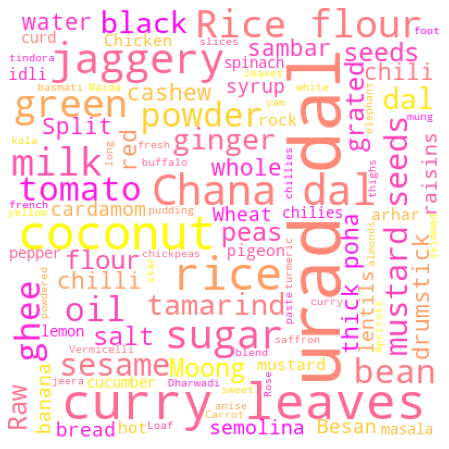

In [14]:
south_data = df[df['region']=='South'].reset_index()

ingredients = []
for i in range(0,len(south_data)):
    text = south_data['ingredients'][i].split(',')
    text = ','.join(text)
    ingredients.append(text)
    text = ' '.join(ingredients)

wordcloud = WordCloud(width = 400, height = 400, colormap = 'spring',
                      background_color ='white', min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

#### Different Dishes

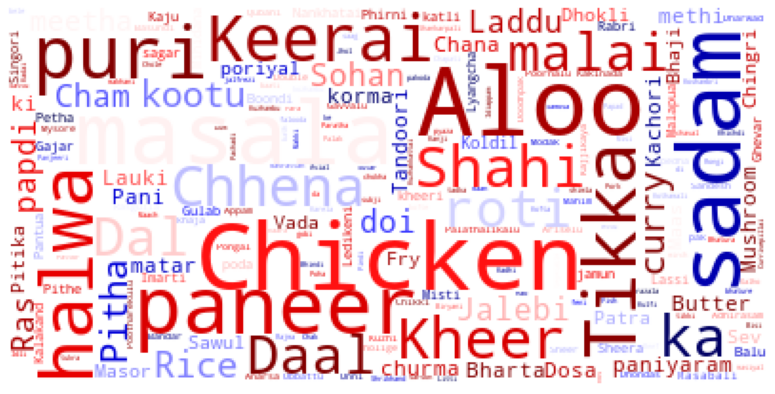

In [15]:
wordCloud = WordCloud(
    background_color='White', colormap = 'seismic', 
    max_font_size = 50).generate(' '.join(df['name']))

plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(wordCloud)
plt.show()

## Histograms

<Figure size 1008x504 with 0 Axes>

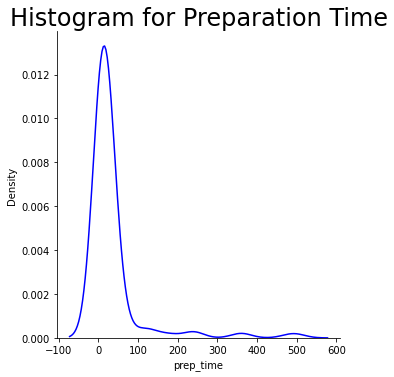

In [17]:
plt.figure(figsize=(14,7))

sns.displot(df['prep_time'], color='blue', kind='kde')
plt.title("Histogram for Preparation Time", fontsize=24)
plt.show()

There are some outliers in the data. We need to handle outliers before building the model.

<Figure size 1008x576 with 0 Axes>

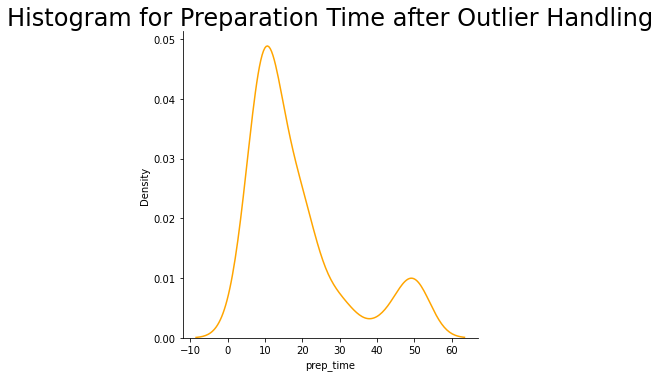

In [18]:
# Handling outliers for prep_time 

# as our data is skewed so we will compute the Interquantile range to calculate the boundaries

IQR=df['prep_time'].quantile(0.75)-df['prep_time'].quantile(0.25)
lower_bridge=df['prep_time'].quantile(0.25)-(IQR*1.5)
upper_bridge=df['prep_time'].quantile(0.75)+(IQR*1.5)

#print(lower_bridge), print(upper_bridge)

#### Extreme outliers
lower_bridge=df['prep_time'].quantile(0.25)-(IQR*3)
upper_bridge=df['prep_time'].quantile(0.75)+(IQR*3)

#print(lower_bridge), print(upper_bridge)

df.loc[df['prep_time']>=50,'prep_time']=50


plt.figure(figsize=(14,8))
sns.displot(df['prep_time'],color='orange', kind='kde')
plt.title("Histogram for Preparation Time after Outlier Handling", fontsize=24)
plt.show()

## Data Pre-Processing

In [20]:
#Finding null counts in the dataset

df.isna().sum()

name               0
ingredients        0
diet               0
prep_time         30
cook_time         28
flavor_profile    29
course             0
state             24
region            14
dtype: int64

In [21]:
food_vocab = set()

for ingredients in df['ingredients']:
    for food in ingredients.split(','):
        if food.strip().lower() not in food_vocab:
            food_vocab.add(food.strip().lower())

In [22]:
print(food_vocab)

{'white urad dal', 'masala', 'reduced milk', 'drumsticks', 'cardamom', 'whole wheat flour', 'green garlic chutney', 'sugar', 'dry dates', 'heavy cream', 'desiccated coconut', 'litre milk', 'carrots', 'paneer', 'badam', 'tandoori masala', 'gooseberry', 'apricots', 'red pepper', 'wine vinegar', 'urad dal', 'firm white pumpkin', 'garam masala powder', 'wild mushrooms', 'biryani masala', 'masoor dal', 'poppy seeds', 'baby potatoes', 'split urad dal', 'coconut oil', 'green moong beans', 'chenna cheese', 'potato', 'yellow moong daal', 'egg yolks', 'chickpea flour', 'bombay rava', 'beans', 'sweet potato', 'bay leaf', 'sauce', 'low fat', 'baby corn', 'frozen green peas', 'fish fillet', 'sorghum flour', 'pork', 'khoa', 'fresh coconut', 'dried rose petals', 'musk melon seeds', 'black salt', 'lentil flour', 'aloo', 'cardamom pods', 'lemon', 'chana dal', 'garlic powder', 'elachi', 'pigeon peas', 'boiled potatoes', 'black lentils', 'garlic', 'tamarind paste', 'peanut', 'semolina', 'pearl millet flo

In [23]:
food_columns = pd.DataFrame()

for i, ingredients in enumerate(df['ingredients']):
    for food in ingredients.split(','):
        if food.strip().lower() in food_vocab:
            food_columns.loc[i, food.strip().lower()] = 1

food_columns = food_columns.fillna(0)

In [24]:
food_columns.head()

,maida flour,yogurt,oil,sugar,gram flour,ghee,carrots,milk,cashews,raisins,flour,kewra,clarified butter,almonds,pistachio,saffron,green cardamom,milk powder,plain flour,baking powder,water,rose water,sugar syrup,lentil flour,maida,corn flour,baking soda,vinegar,curd,turmeric,cardamom,cottage cheese,rice,dried fruits,nuts,refined flour,besan,powdered sugar,yoghurt,firm white pumpkin,...,orange rind,raw papaya,panch phoran masala,eggs,beetroot,brinjal,forbidden black rice,slivered almonds,garlic powder,biryani masala,mixed vegetables,yellow moong daal,whole red,brown rice,soy sauce,coconut milk,lobster,fresh green chilli,lamb,prawns,mustard seed,fish fillet,mint,fermented bamboo shoot,banana flower,mutton,fish roe,pumpkin flowers,dry chilli,tea leaves,soaked rice,cardamom pods,red pepper,watercress,glutinous rice,egg yolks,dry dates,dried rose petals,arrowroot powder,ginger powder
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df = df.drop(['name', 'ingredients'], axis=1)

In [26]:
{column: list(df[column].unique()) for column in df.columns if df.dtypes[column] == 'object'}

{'course': ['dessert', 'main course', 'starter', 'snack'],
 'diet': ['vegetarian', 'non vegetarian'],
 'flavor_profile': ['sweet', 'spicy', 'bitter', nan, 'sour'],
 'region': ['East', 'West', 'North', nan, 'North East', 'South', 'Central'],
 'state': ['West Bengal',
  'Rajasthan',
  'Punjab',
  'Uttar Pradesh',
  nan,
  'Odisha',
  'Maharashtra',
  'Uttarakhand',
  'Assam',
  'Bihar',
  'Andhra Pradesh',
  'Karnataka',
  'Telangana',
  'Kerala',
  'Tamil Nadu',
  'Gujarat',
  'Tripura',
  'Manipur',
  'Nagaland',
  'NCT of Delhi',
  'Jammu & Kashmir',
  'Chhattisgarh',
  'Haryana',
  'Madhya Pradesh',
  'Goa']}

In [27]:
df[['flavor_profile', 'state', 'region']] = df[['flavor_profile', 'state', 'region']].replace('-1', np.NaN)

In [28]:
#Performing One-Hot Encoding for the categorical variables using the get_dummies
#function, and changing the column names

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

df = onehot_encode(
    df,
    ['flavor_profile', 'course', 'state', 'region'],
    ['f', 'c', 's', 'r']
)

In [29]:
df

,diet,prep_time,cook_time,f_bitter,f_sour,f_spicy,f_sweet,c_dessert,c_main course,c_snack,c_starter,s_Andhra Pradesh,s_Assam,s_Bihar,s_Chhattisgarh,s_Goa,s_Gujarat,s_Haryana,s_Jammu & Kashmir,s_Karnataka,s_Kerala,s_Madhya Pradesh,s_Maharashtra,s_Manipur,s_NCT of Delhi,s_Nagaland,s_Odisha,s_Punjab,s_Rajasthan,s_Tamil Nadu,s_Telangana,s_Tripura,s_Uttar Pradesh,s_Uttarakhand,s_West Bengal,r_Central,r_East,r_North,r_North East,r_South,r_West
0,vegetarian,45.0,25.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,vegetarian,50.0,30.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,vegetarian,15.0,60.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,vegetarian,15.0,30.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,vegetarian,15.0,40.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,vegetarian,5.0,30.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
251,vegetarian,20.0,60.0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
252,vegetarian,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
253,vegetarian,20.0,45.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [30]:
#Removing negative prep_times and cook_times

df[['prep_time', 'cook_time']] = df[['prep_time', 'cook_time']].replace(-1, np.NaN)

In [31]:
df

,diet,prep_time,cook_time,f_bitter,f_sour,f_spicy,f_sweet,c_dessert,c_main course,c_snack,c_starter,s_Andhra Pradesh,s_Assam,s_Bihar,s_Chhattisgarh,s_Goa,s_Gujarat,s_Haryana,s_Jammu & Kashmir,s_Karnataka,s_Kerala,s_Madhya Pradesh,s_Maharashtra,s_Manipur,s_NCT of Delhi,s_Nagaland,s_Odisha,s_Punjab,s_Rajasthan,s_Tamil Nadu,s_Telangana,s_Tripura,s_Uttar Pradesh,s_Uttarakhand,s_West Bengal,r_Central,r_East,r_North,r_North East,r_South,r_West
0,vegetarian,45.0,25.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,vegetarian,50.0,30.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,vegetarian,15.0,60.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,vegetarian,15.0,30.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,vegetarian,15.0,40.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,vegetarian,5.0,30.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
251,vegetarian,20.0,60.0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
252,vegetarian,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
253,vegetarian,20.0,45.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [32]:
#Replacing NaN values with the mean of that particular column (data imputation)

df['prep_time'] = df['prep_time'].fillna(df['prep_time'].mean())
df['cook_time'] = df['cook_time'].fillna(df['cook_time'].mean())

In [33]:
df

,diet,prep_time,cook_time,f_bitter,f_sour,f_spicy,f_sweet,c_dessert,c_main course,c_snack,c_starter,s_Andhra Pradesh,s_Assam,s_Bihar,s_Chhattisgarh,s_Goa,s_Gujarat,s_Haryana,s_Jammu & Kashmir,s_Karnataka,s_Kerala,s_Madhya Pradesh,s_Maharashtra,s_Manipur,s_NCT of Delhi,s_Nagaland,s_Odisha,s_Punjab,s_Rajasthan,s_Tamil Nadu,s_Telangana,s_Tripura,s_Uttar Pradesh,s_Uttarakhand,s_West Bengal,r_Central,r_East,r_North,r_North East,r_South,r_West
0,vegetarian,45.00,25.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,vegetarian,50.00,30.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,vegetarian,15.00,60.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,vegetarian,15.00,30.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,vegetarian,15.00,40.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,vegetarian,5.00,30.000000,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
251,vegetarian,20.00,60.000000,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
252,vegetarian,18.52,38.911894,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
253,vegetarian,20.00,45.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [34]:
#Label encoding the target attribute

label_encoder = LabelEncoder()

df['diet'] = label_encoder.fit_transform(df['diet'])

In [35]:
{index: label for index, label in enumerate(label_encoder.classes_)}

{0: 'non vegetarian', 1: 'vegetarian'}

In [36]:
y = df['diet']

X = df.drop('diet', axis=1)
X_food = pd.concat([X, food_columns], axis=1)

X_food.head()

,prep_time,cook_time,f_bitter,f_sour,f_spicy,f_sweet,c_dessert,c_main course,c_snack,c_starter,s_Andhra Pradesh,s_Assam,s_Bihar,s_Chhattisgarh,s_Goa,s_Gujarat,s_Haryana,s_Jammu & Kashmir,s_Karnataka,s_Kerala,s_Madhya Pradesh,s_Maharashtra,s_Manipur,s_NCT of Delhi,s_Nagaland,s_Odisha,s_Punjab,s_Rajasthan,s_Tamil Nadu,s_Telangana,s_Tripura,s_Uttar Pradesh,s_Uttarakhand,s_West Bengal,r_Central,r_East,r_North,r_North East,r_South,r_West,...,orange rind,raw papaya,panch phoran masala,eggs,beetroot,brinjal,forbidden black rice,slivered almonds,garlic powder,biryani masala,mixed vegetables,yellow moong daal,whole red,brown rice,soy sauce,coconut milk,lobster,fresh green chilli,lamb,prawns,mustard seed,fish fillet,mint,fermented bamboo shoot,banana flower,mutton,fish roe,pumpkin flowers,dry chilli,tea leaves,soaked rice,cardamom pods,red pepper,watercress,glutinous rice,egg yolks,dry dates,dried rose petals,arrowroot powder,ginger powder
0,45.0,25.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,30.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,60.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,30.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15.0,40.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#Normalizing the feature attributes to prevent bias

scaler = StandardScaler()

X = scaler.fit_transform(X)
X_food = scaler.fit_transform(X_food)

In [38]:
#Perform over-sampling, since the dataset is highly biased.
#Otherwise, the model will be biased towards vegetarian food,
#and work poorly in classifying non-vegetarian data.

ovs = RandomOverSampler(random_state=42)

X_food, y_food = ovs.fit_sample(X_food, y)
X, y = ovs.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [39]:
print(len(X_food))
print(len(y))

452
452


In [40]:
X_food.shape

(452, 405)

In [41]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_food_train, X_food_test, y_food_train, y_food_test = train_test_split(X_food, y, train_size=0.7, random_state=42)

## Building & Training an Artificial Neural Network

In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Artificial Neural Network Architecture
model = Sequential()
model.add(Dense(1024, input_dim=405, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Hyper-Parameters
EPOCHS = 100
BATCH_SIZE = 64

#To reduce the learning rate when the validation loss stops improving, to prevent overfitting
#my_callbacks = [ReduceLROnPlateau(monitor='val_loss')]

#Early stopping to prevent overfitting of model to training data
my_callbacks = [EarlyStopping(monitor='val_loss', patience=10),
               ReduceLROnPlateau(monitor='val_loss')]

#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.AUC(name='auc')])

#Fit the model and train it on the training set
history = model.fit(X_food_train, y_food_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=my_callbacks, verbose=2)

Epoch 1/100
4/4 - 2s - loss: 0.7926 - accuracy: 0.5873 - auc: 0.6541 - val_loss: 0.5215 - val_accuracy: 0.6719 - val_auc: 1.0000
Epoch 2/100
4/4 - 0s - loss: 0.2005 - accuracy: 0.9127 - auc: 0.9997 - val_loss: 0.0955 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/100
4/4 - 0s - loss: 0.0420 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0470 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/100
4/4 - 0s - loss: 0.0167 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0148 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 5/100
4/4 - 0s - loss: 0.0038 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0112 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 6/100
4/4 - 0s - loss: 0.0018 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 7/100
4/4 - 0s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0124 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 8/100
4/4 - 0s - loss: 8.3987e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0131 - val

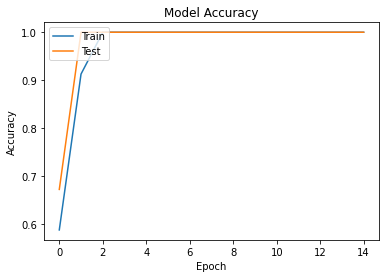

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

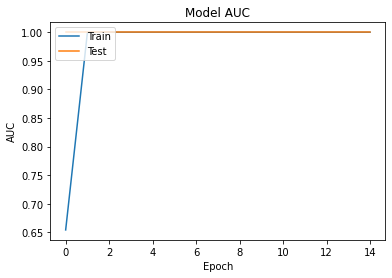

In [44]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
model.evaluate(X_food_test, y_food_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.9632 - auc: 0.9980


[0.0706973671913147, 0.9632353186607361, 0.9980498552322388]

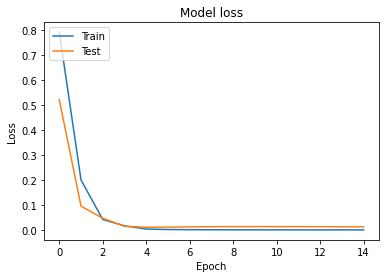

In [46]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [47]:
y_food_pred = model.predict(X_food_test)
y_food_pred = np.round(y_food_pred)

#print(list(y_food_pred), list(y_food_test))
print(classification_report(y_food_test, y_food_pred))
print("Balanced Accuracy Score:", round(bas(y_food_test, y_food_pred) * 100, 2) , "%")
print("Matthew's Correlation Coefficient:", round(mcc(y_food_test, y_food_pred) * 100, 2) , "%")
print("Accuracy Score:", round(accuracy_score(y_food_test, y_food_pred) * 100, 2), "%")

print("\nConfusion Matrix:\n", confusion_matrix(y_food_test, y_food_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        65
           1       0.96      0.97      0.97        71

    accuracy                           0.96       136
   macro avg       0.96      0.96      0.96       136
weighted avg       0.96      0.96      0.96       136

Balanced Accuracy Score: 96.28 %
Matthew's Correlation Coefficient: 92.64 %
Accuracy Score: 96.32 %

Confusion Matrix:
 [[62  3]
 [ 2 69]]


In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_food_train, y_food_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
y_food_pred = rf.predict(X_food_test)
y_food_pred = np.round(y_food_pred)

#print(list(y_food_pred), list(y_food_test))
print(classification_report(y_food_test, y_food_pred))
print("Balanced Accuracy Score:", round(bas(y_food_test, y_food_pred) * 100, 2) , "%")
print("Matthew's Correlation Coefficient:", round(mcc(y_food_test, y_food_pred) * 100, 2) , "%")
print("Accuracy Score:", round(accuracy_score(y_food_test, y_food_pred) * 100, 2), "%")

print("\nConfusion Matrix:\n", confusion_matrix(y_food_test, y_food_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        65
           1       1.00      0.96      0.98        71

    accuracy                           0.98       136
   macro avg       0.98      0.98      0.98       136
weighted avg       0.98      0.98      0.98       136

Balanced Accuracy Score: 97.89 %
Matthew's Correlation Coefficient: 95.68 %
Accuracy Score: 97.79 %

Confusion Matrix:
 [[65  0]
 [ 3 68]]
